In [175]:
import torch
import torch.nn as nn

print(torch.cuda.is_available())

print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import numpy as np
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups, if any
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example usage
set_seed(58)  # Replace 42 with your chosen seed

phase = 1

True
2
cuda


In [176]:
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler

def normalizaData(df):
    # Convert DataFrame to PyTorch Tensor and send to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Normalizing Angular Data (Robotic Joints)
    rad_cols = ['Tool_rx', 'Tool_ry', 'Tool_rz', 'Joint_base', 'Joint_Shoulder', 'Joint_Elbow', 'Joint_W1', 'Joint_W2', 'Joint_W3']
    for col in rad_cols:
        # Ensure the data is in the form of a PyTorch Tensor
        rad_tensor = torch.tensor(df[col].values, device=device, dtype=torch.float32)
        df[col + '_cos'] = torch.cos(rad_tensor).cpu().numpy()  # Compute cosine and convert back to NumPy for DataFrame
        df[col + '_sin'] = torch.sin(rad_tensor).cpu().numpy()  # Compute sine and convert back to NumPy for DataFrame
    
    # Normalizing Linear Data (Speed, Acceleration, Energy Consumed, and Time)
    # Min-Max Scaling: Scales the data to a fixed range, typically 0 to 1
    scaler = MinMaxScaler()
    linear_cols = ['Speed', 'Acceleration', 'Time', 'Energy_Consumped']
    df[linear_cols] = scaler.fit_transform(df[linear_cols])
    
    return df, scaler


In [177]:
def denormalize_data(arr, scaler, features):
    
    """
    Denormalizes the data from a normalized array using the provided scaler.
    
    Parameters:
    - arr (numpy.ndarray): The normalized array to be denormalized. Expected shape: (samples, features, timesteps).
    - scaler (MinMaxScaler or StandardScaler): The scaler used to normalize the data.
    - features (list): List of feature names for the DataFrame.
    
    Returns:
    - pd.DataFrame: A DataFrame with denormalized data.
    """
    
    # Reshape array into 2D (flatten the timesteps) and create DataFrame
    reshaped_array = arr.reshape(-1, arr.shape[2])
    df = pd.DataFrame(reshaped_array, columns=features)
    
    # Denormalizing Angular Data
    # Identify columns related to cosine and sine representations
    angle_columns = [col for col in df.columns if '_cos' in col or '_sin' in col]
    
    # Set to keep track of processed base columns to avoid duplicates
    processed_bases = set()
    
    for col in angle_columns:
        if '_cos' in col:
            base_col = col.replace('_cos', '')
            if base_col not in processed_bases:
                # Combine cosine and sine to compute the angle
                df[base_col] = np.arctan2(df[base_col + '_sin'], df[base_col + '_cos'])
                # Remove the original cosine and sine columns
                df.drop(columns=[base_col + '_sin', base_col + '_cos'], inplace=True)
                # Mark the base column as processed
                processed_bases.add(base_col)
    
    # Denormalizing Linear Data
    # List of columns to denormalize
    linear_columns = ['Speed', 'Acceleration', 'Time', 'Energy_Consumped']
    
    # Ensure all specified columns are in the DataFrame before attempting denormalization
    available_linear_columns = [col for col in linear_columns if col in df.columns]
    
    if available_linear_columns:
        df[available_linear_columns] = scaler.inverse_transform(df[available_linear_columns])
    return df

In [178]:
import pandas as pd
import torch

# Load data
real_data = pd.read_csv('phase RLHF dataset/remaining_paths.csv')

# Fix a typo in the 'point_type' column
real_data['point_type'] = real_data['point_type'].replace('approuch', 'approach')

# Map 'point_type' and 'Movement Type' to numeric values
points = {'pick': 1, 'approach': 2, 'start_point': 3, 'box1': 4, 'way_point': 5}
movement_types = {'MoveL': 1, 'MoveJ': 2, 'Movel': 1, 'Movej': 2}
real_data['point_type'] = real_data['point_type'].map(points)
real_data['Movement Type'] = real_data['Movement Type'].map(movement_types)

# Drop columns 'id' and 'row_index'
real_data.drop(['id'], axis=1, inplace=True)

# Assuming here that the use of PyTorch would be to handle numeric data for neural network processing
# Convert DataFrame to PyTorch Tensor and send to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tensor_data = torch.tensor(real_data.values, dtype=torch.float, device=device)

# Print number of columns in the DataFrame
print(len(real_data.columns))

21


In [179]:
# Normalize the data
df_normalized, scaler = normalizaData(real_data.copy())

# Define the features to be used
features = [
    'point_type', 'Tool_x', 'Tool_y', 'Tool_z', 'Tool_rx_cos', 'Tool_rx_sin', 'Tool_ry_cos',
    'Tool_ry_sin', 'Tool_rz_cos', 'Tool_rz_sin', 'Joint_base_cos',
    'Joint_base_sin', 'Joint_Shoulder_cos', 'Joint_Shoulder_sin',
    'Joint_Elbow_cos', 'Joint_Elbow_sin', 'Joint_W1_cos', 'Joint_W1_sin',
    'Joint_W2_cos', 'Joint_W2_sin', 'Joint_W3_cos', 'Joint_W3_sin', 'Speed', 'Acceleration', 'Movement Type', 'Time', 'Energy_Consumped'
]

# Calculate the number of features
features_num = len(features)

# Select the specified features from the normalized DataFrame
df_normalized = df_normalized[features]

# Display the first few rows of the selected features
df_normalized.head()

,point_type,Tool_x,Tool_y,Tool_z,Tool_rx_cos,Tool_rx_sin,Tool_ry_cos,Tool_ry_sin,Tool_rz_cos,Tool_rz_sin,...,Joint_W1_sin,Joint_W2_cos,Joint_W2_sin,Joint_W3_cos,Joint_W3_sin,Speed,Acceleration,Movement Type,Time,Energy_Consumped
0,1,-0.433523,0.333936,-0.030139,-1.000000,-0.000246,0.999676,-0.025465,1.000000,-0.000176,...,-0.289171,-0.000176,-1.000000,0.794756,0.606929,0.294118,0.636364,1,0.094968,0.223618
1,2,-0.433500,0.333940,0.065696,-0.998283,-0.058572,0.999700,-0.024504,1.000000,-0.000227,...,-0.419781,-0.036299,-0.999341,0.790968,0.611858,0.282353,1.000000,1,0.047984,0.224316
2,3,0.016570,0.625812,0.208685,-1.000000,0.000109,0.999664,0.025907,1.000000,-0.000093,...,-0.807036,0.000057,-1.000000,0.967018,-0.254709,0.062353,0.001705,2,0.231589,0.398801
3,4,0.095151,0.625719,0.050709,-1.000000,0.000160,0.999670,0.025671,1.000000,-0.000062,...,-0.577087,0.000017,-1.000000,0.928864,-0.370420,0.176471,0.636364,2,0.141286,0.323782
4,5,0.224429,0.625729,0.004486,-0.999842,0.017800,0.999676,0.025435,0.950254,0.311477,...,-0.446884,-0.174249,-0.984702,0.855188,-0.518318,0.011765,0.000000,2,0.084972,0.226819


In [180]:
import numpy as np
import pandas as pd

# Assuming df_normalized has been defined and features_num has been calculated as before
# Add a 'path_id' column to help in grouping. Creating a dummy 'path_id' that repeats every 5 rows
num_paths = len(df_normalized) // 5  # Use integer division
path_id = np.repeat(np.arange(num_paths), 5)
df_normalized['path_id'] = path_id

# Ensure the length of path_id matches the number of rows in df_normalized
if len(path_id) < len(df_normalized):
    extra_ids = np.array([num_paths] * (len(df_normalized) - len(path_id)))
    path_id = np.concatenate([path_id, extra_ids])

# Now, sort and group by 'path_id' and reshape
grouped = df_normalized.groupby('path_id').apply(lambda x: x.iloc[:, :-1].values.reshape(1, 5, features_num))

# Drop the 'path_id' column after reshaping
df_normalized.drop(['path_id'], axis=1, inplace=True)

# Concatenate the groups back into a single numpy array
reshaped_data = np.concatenate(grouped.values, axis=0)

# Save the reshaped data to a file. Assume 'phase' is defined elsewhere
np.save(f"CGANreal_normalized_dataset_shape_3D_ph{phase}.npy", reshaped_data)

/tmp/ipykernel_158/1721696532.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_normalized.groupby('path_id').apply(lambda x: x.iloc[:, :-1].values.reshape(1, 5, features_num))


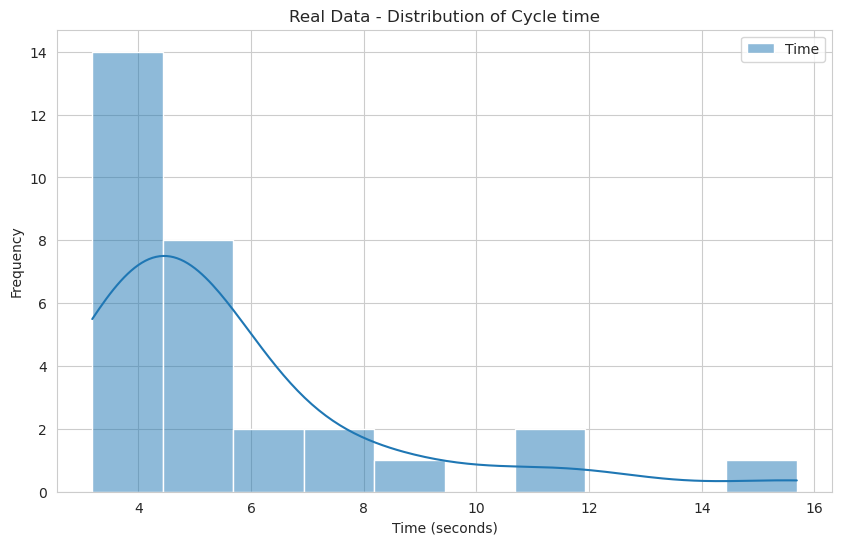

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt
# Setting the aesthetic style of the plots
sns.set_style('whitegrid')

col_16 = real_data['Time']
summed_time = col_16.groupby(real_data.index // 5).sum()
plt.figure(figsize=(10, 6))
sns.histplot(summed_time, kde=True, bins=10 , label = "Time")
plt.title('Real Data - Distribution of Cycle time')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig("Real Data - Distribution of Cycle time")
plt.show()

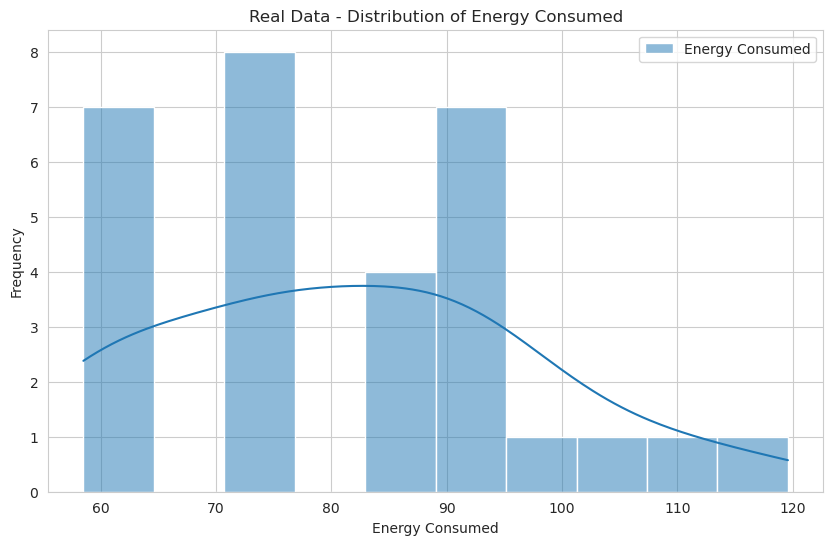

In [182]:

col_17 = real_data['Energy_Consumped']
summed_energy_consumed = col_17.groupby(real_data.index // 5).sum()
plt.figure(figsize=(10, 6))

sns.histplot(summed_energy_consumed, kde=True, bins=10, label="Energy Consumed")
plt.title('Real Data - Distribution of Energy Consumed')
plt.xlabel('Energy Consumed')
plt.ylabel('Frequency')
plt.legend()
plt.savefig("Real Data - Distribution of Energy Consumed_2.pdf")
plt.show()

In [183]:
class Generator(nn.Module):
    def __init__(self, noise_dim, cond_dim, features_num, sequence_length= 5):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.cond_dim = cond_dim
        self.features_num = features_num
        self.sequence_length = sequence_length

        self.fc_initial = nn.Sequential(
            nn.Linear(self.noise_dim + self.cond_dim, 5 * self.features_num),
            nn.LeakyReLU(0.2)
        )
        self.relu =  nn.LeakyReLU(0.2)
        # Define LSTM layers
        self.lstm1 = nn.LSTM(self.features_num, 1024, batch_first=True)
        self.lstm2 = nn.LSTM(1024, 256, batch_first=True)
        self.lstm3 = nn.LSTM(256, 128, batch_first=True)
        self.lstm4 = nn.LSTM(128, 64, batch_first=True)
        self.lstm5 = nn.LSTM(64, 64, batch_first=True)

        self.final_layer = nn.Sequential(
            nn.Linear(64, self.features_num),
            nn.Tanh()
        )

    def forward(self, noise, condition):
        # Flatten the condition to concatenate with noise
        condition_flat = condition.reshape(noise.size(0), -1)  # Flatten condition

        merged_input = torch.cat([noise, condition_flat], dim=1)

        # Process the initial input and reshape for sequence processing
        x = self.fc_initial(merged_input)
        x = x.view(-1, self.sequence_length, self.features_num)
        # Passing through LSTM layers
        x, _ = self.lstm1(x)
        x = self.relu(x)
        x, _ = self.lstm2(x)
        x = self.relu(x)
        x, _ = self.lstm3(x)
        x = self.relu(x)
        x, _ = self.lstm4(x)
        x = self.relu(x)
        x, _ = self.lstm5(x)

        # Apply final transformation to each time point
        x = self.final_layer(x)
        return x

# Initialize and move the generator to GPU
noise_dim = 100
cond_dim = 10  # 5 time points, each with 2 features flattened

generator = Generator(noise_dim, cond_dim, features_num)
generator.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Generator(
  (fc_initial): Sequential(
    (0): Linear(in_features=110, out_features=135, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
  )
  (relu): LeakyReLU(negative_slope=0.2)
  (lstm1): LSTM(27, 1024, batch_first=True)
  (lstm2): LSTM(1024, 256, batch_first=True)
  (lstm3): LSTM(256, 128, batch_first=True)
  (lstm4): LSTM(128, 64, batch_first=True)
  (lstm5): LSTM(64, 64, batch_first=True)
  (final_layer): Sequential(
    (0): Linear(in_features=64, out_features=27, bias=True)
    (1): Tanh()
  )
)

In [184]:
class Discriminator(nn.Module):
    def __init__(self, features_num):
        super(Discriminator, self).__init__()
        self.features_num = features_num
        self.input_shape = (5, features_num)  # Shape of input data
        self.condition_shape = (5, 2)  # Same as in the generator
        self.lstm_input_size = features_num + 2  # The input size for the first LSTM layer, which is the sum of features_num and 10 (presumably the length of the flattened conditioning information).
        # LSTM layers
        self.lstm1 = nn.LSTM(self.lstm_input_size, 1024, batch_first=True)
        self.lstm2 = nn.LSTM(1024, 256, batch_first=True)
        self.lstm3 = nn.LSTM(256, 128, batch_first=True)
        self.lstm4 = nn.LSTM(128, 32, batch_first=True)
        self.lstm5 = nn.LSTM(32, 32, batch_first=True)
        self.lstm6 = nn.LSTM(32, 32, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(0.3)

        # Fully connected layer
        self.fc = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.LeakyReLU(0.2)


    def forward(self, x, condition):
        batch_size, seq_len, _ = x.size()

        # Reshape condition to match input data for concatenation
        condition_flat = condition.view(batch_size, seq_len, -1)
        # Concatenate input data and condition
        merged_input = torch.cat([x, condition_flat], dim=2)

        # Apply SSE module
        #print(merged_input.shape, "merged_input before")
        #merged_input = merged_input.permute(0, 1, 2)  # Change shape to (batch, channels, length)
        #print(merged_input.shape, "merged_input")
       # (None, 5, 29) merged_input

        #sse_out = sse_module(merged_input)
        #sse_out = sse_out.permute(0, 2, 1)  # Change back to (batch, length, channels)
        #print(sse_out.shape,"sse_out")
        # LSTM layers
        x, _ = self.lstm1(merged_input)
        x = self.relu(x)
        x, _ = self.lstm2(x)
        x = self.relu(x)
        x, _ = self.lstm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x, _ = self.lstm4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x, _ = self.lstm5(x)
        x = self.relu(x)
        x, _ = self.lstm6(x)

        # Take the output from the last LSTM step
        x = x[:, -1, :]

        # Apply fully connected layer
        x = self.fc(x)
        x = self.sigmoid(x) # Apply sigmoid to output the probability
        return x


In [185]:
def physics_loss(fake_data):
    """
    Calculate the physics-based loss for generated data.

    Parameters:
    - fake_data (torch.Tensor): Generated data with shape (batch_size, seq_len, num_features).

    Returns:
    - torch.Tensor: Total physics loss.
    """
    fake_data_numpy = fake_data.detach().cpu().numpy()

    df = denormalize_data(fake_data_numpy , scaler, features)
    '''Index(['point_type', 'Tool_x', 'Tool_y', 'Tool_z', 'Speed', 'Acceleration',
       'Movement Type', 'Time', 'Energy_Consumped', 'Tool_rx', 'Tool_ry',
       'Tool_rz', 'Joint_base', 'Joint_Shoulder', 'Joint_Elbow', 'Joint_W1',
       'Joint_W2', 'Joint_W3'],
      dtype='object') '''
    #Penalty for negative values in specific columns

    #Movement type 1-> moveL , 2-> moveJ 
    #Tool x,y,z # Move l ,speed 0-3000 mm/s -> 0-3 m/s
    #Tool x,y,z # Move l ,acceleration 0-150000 mm/s2 - 0-150 m/s 
    #Denormalize speed , 13 index in real data , 22 speed in normalized data
    #[-25.2721, -25.7903, -25.5148, -25.1693, -24.9287],

    # Speed constraints for MoveL
    # i assume movment type = 1 if less than 0.5 
    filtered_speed = len(df[(df['Speed'] >= 0) & (df['Speed'] <= 3) & (df['Movement Type'] <= 1)])
    filtered_Acceleration = len(df[(df['Acceleration'] >= 0) & (df['Acceleration'] <= 150) & (df['Movement Type'] <= 1)])
    speed_loss_l = filtered_speed
    acc_loss_l = filtered_Acceleration
  

    # Speed constraints for MoveJ
        #rx,ry,rz,joints 
        #Move J speed 0-180 degree per second -> radian 3.14159
        #Move J acceleration 0 - 2292  degree/second ^2 -> radian 40
    filtered_speed_mj = len(df[(df['Speed'] >= 0) & (df['Speed'] <=  3.14159) & (df['Movement Type'] >=1)])
    filtered_Acceleration_mj = len(df[(df['Acceleration'] >= 0) & (df['Acceleration'] <= 40) & (df['Movement Type'] >= 1)])
    speed_loss_j = filtered_speed_mj
    acc_loss_j = filtered_Acceleration_mj
  

    # Joint angle constraints
       #validate_joint_angles
        #-363 to 363 degree/s ---->    -6.33555 , 6.33555 rad
        #Joint limits as defined in the screenshot
    joint_columns = ['Joint_base', 'Joint_Shoulder', 'Joint_Elbow', 'Joint_W1', 'Joint_W2', 'Joint_W3']
    # Filter the DataFrame
    filtered_df_joints = df[(df[joint_columns] < -6.33555) | (df[joint_columns] > 6.33555)].dropna(how='all', subset=joint_columns)
    joints_loss = len(filtered_df_joints)
   
    #time, energy negative 
    filtered_df = df[(df['Time'] < 0) | (df['Energy_Consumped'] < 0)]
    time_energy_loss = len(filtered_df)
    total_loss = speed_loss_l + acc_loss_l + speed_loss_j + acc_loss_j + joints_loss + time_energy_loss
    return total_loss


In [186]:
import torch

def generate_noise(batch_size, noise_dim, seed=None):
    """
    Generate uniform noise for the GAN.

    Parameters:
    - batch_size (int): Number of samples.
    - noise_dim (int): Dimensionality of the noise vector.
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - torch.Tensor: Noise tensor.
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    #noise = torch.rand(batch_size, noise_dim).to('cuda' if torch.cuda.is_available() else 'cpu')

    return torch.randn(batch_size, noise_dim).to('cuda' if torch.cuda.is_available() else 'cpu')



In [187]:

import torch.optim as optim

def setup_gan(generator, discriminator, lr=0.0002):
    """
    Setup the GAN by initializing optimizers and moving models to the appropriate device.

    Parameters:
    - generator (nn.Module): The generator model.
    - discriminator (nn.Module): The discriminator model.
    - lr (float): Learning rate for the optimizers.

    Returns:
    - Tuple of optimizers for generator and discriminator.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)
    print("discriminator")
    print(discriminator)
    optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002
                            , betas=(0.5, 0.999))

    return optimizer_g, optimizer_d, device


In [188]:
# Define the loss function
criterion = nn.BCELoss()
from torch.utils.data import TensorDataset, DataLoader

def train(generator, discriminator, optimizer_g, optimizer_d, device, epochs, noise_dim, conditions,phy_factor_param):
    """
    Train the GAN using Wasserstein loss with gradient penalty for the entire dataset at once.

    Parameters:
    - generator (nn.Module): The generator model.
    - discriminator (nn.Module): The discriminator model.
    - optimizer_g (torch.optim.Optimizer): Optimizer for the generator.
    - optimizer_d (torch.optim.Optimizer): Optimizer for the discriminator.
    - device (torch.device): Device to run computations on (CPU or GPU).
    - epochs (int): Number of training epochs.
    - noise_dim (int): Dimension of the noise vector.
    - reshaped_data (numpy.ndarray): Real data samples.
    - conditions (numpy.ndarray): Conditional information.
    """
    # Convert reshaped_data and conditions to PyTorch tensors and move to device
    
    conditions = torch.tensor(conditions, dtype=torch.float).to(device)
    tensor_data = torch.tensor(reshaped_data, dtype=torch.float32).to(device)
    dataset = TensorDataset(tensor_data)
    data_loader = DataLoader(dataset, batch_size=33, shuffle=True)

    losses = []

    for epoch in range(epochs):
     for real_data_tensor, in data_loader:
        real_data_tensor = real_data_tensor.to(device)
        # Generate real data samples
        real_data_batch = real_data_tensor
        gen_conditions = conditions

        # Generate synthetic data samples
        
        noise = generate_noise(len(real_data_batch), noise_dim).to(device)
         
        fake_data = generator(noise, gen_conditions)
       
        # === Train Discriminator ===
        optimizer_d.zero_grad()
        real_validity = discriminator(real_data_batch, gen_conditions)
        fake_validity = discriminator(fake_data.detach(), gen_conditions)

        # Compute Wasserstein loss for discriminator
        # Real data loss
        real_loss = criterion(real_validity, torch.ones_like(real_validity))        
        # Fake data loss
        fake_loss = criterion(fake_validity, torch.zeros_like(fake_validity))
        
        d_loss = (real_loss + fake_loss) / 2 
        optimizer_d.step()

        # === Train Generator ===
        optimizer_g.zero_grad()
        # Generate fake data again for generator update
        fake_data = generator(noise, gen_conditions)
        fake_validity = discriminator(fake_data, gen_conditions)
        phy_factor = phy_factor_param
        g_loss = criterion(fake_validity, torch.ones_like(fake_validity)) + phy_factor * physics_loss(fake_data)
        g_loss.backward()
        optimizer_g.step()

        # Optionally print the progress for each batch or save it
        losses.append({"epoch": epoch, "D Loss": d_loss.item(), "G Loss": g_loss.item()})
        if (epoch+1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
         
    g_losses = [loss['G Loss'] for loss in losses]  
    return generator, discriminator, np.mean(g_losses), losses



In [189]:
# Parameters
epochs = 5000
batch_size = 33  # Set batch_size appropriately
noise_dim = 100  # Dimensionality of the input noise vector
num_features = 27

discriminator = Discriminator(features_num)
optimizer_g, optimizer_d, device = setup_gan(generator, discriminator, lr=0.0001)

# Start training
conditions = reshaped_data[:, :, -2:]  # Extract the last two features across all samples

#losses = train(generator, discriminator, optimizer_g, optimizer_d, device, epochs,noise_dim, conditions)


# Start training
# Grid search

best_loss = float('inf')
best_params = {}
phy_factor_param = [0.2] #, 0.5, 1, 2 
lambda_gp=10
for value in phy_factor_param:
    generator, discriminator, gloss, losses = train(generator, discriminator, optimizer_g, optimizer_d, device, epochs,noise_dim, conditions,value)
    if gloss < best_loss:
        best_loss = gloss
        best_params = {"phy_factor_param":value, "generator_model": generator, "discriminator_model": discriminator, "g_best_loss": gloss, "losses":losses}
        
print("Training completed.")

discriminator

discriminator
Discriminator(
  (lstm1): LSTM(29, 1024, batch_first=True)
  (lstm2): LSTM(1024, 256, batch_first=True)
  (lstm3): LSTM(256, 128, batch_first=True)
  (lstm4): LSTM(128, 32, batch_first=True)
  (lstm5): LSTM(32, 32, batch_first=True)
  (lstm6): LSTM(32, 32, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): LeakyReLU(negative_slope=0.2)
)
Epoch 50/5000, D Loss: 0.6930872797966003, G Loss: 24.686567306518555
Epoch 100/5000, D Loss: 0.693149209022522, G Loss: 0.686664342880249
Epoch 150/5000, D Loss: 0.6931191682815552, G Loss: 0.6865479946136475
Epoch 200/5000, D Loss: 0.6931866407394409, G Loss: 12.686572074890137
Epoch 250/5000, D Loss: 0.6932171583175659, G Loss: 24.68657875061035
Epoch 300/5000, D Loss: 0.6931310892105103, G Loss: 30.686525344848633
Epoch 350/5000, D Loss: 0.6931851506233215, G Loss: 30.686607360839844
Epoch 400/5000, D Loss: 0.693210244178772, G Loss: 3

Discriminator(
  (lstm1): LSTM(29, 1024, batch_first=True)
  (lstm2): LSTM(1024, 256, batch_first=True)
  (lstm3): LSTM(256, 128, batch_first=True)
  (lstm4): LSTM(128, 32, batch_first=True)
  (lstm5): LSTM(32, 32, batch_first=True)
  (lstm6): LSTM(32, 32, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): LeakyReLU(negative_slope=0.2)
)

In [190]:
best_params


{'phy_factor_param': 0.2,
 'generator_model': Generator(
   (fc_initial): Sequential(
     (0): Linear(in_features=110, out_features=135, bias=True)
     (1): LeakyReLU(negative_slope=0.2)
   )
   (relu): LeakyReLU(negative_slope=0.2)
   (lstm1): LSTM(27, 1024, batch_first=True)
   (lstm2): LSTM(1024, 256, batch_first=True)
   (lstm3): LSTM(256, 128, batch_first=True)
   (lstm4): LSTM(128, 64, batch_first=True)
   (lstm5): LSTM(64, 64, batch_first=True)
   (final_layer): Sequential(
     (0): Linear(in_features=64, out_features=27, bias=True)
     (1): Tanh()
   )
 ),
 'discriminator_model': Discriminator(
   (lstm1): LSTM(29, 1024, batch_first=True)
   (lstm2): LSTM(1024, 256, batch_first=True)
   (lstm3): LSTM(256, 128, batch_first=True)
   (lstm4): LSTM(128, 32, batch_first=True)
   (lstm5): LSTM(32, 32, batch_first=True)
   (lstm6): LSTM(32, 32, batch_first=True)
   (dropout): Dropout(p=0.3, inplace=False)
   (fc): Linear(in_features=32, out_features=1, bias=True)
   (sigmoid): Sig

In [191]:
# Assuming `generator` and `discriminator` are your model instances
generator = best_params['generator_model']
discriminator = best_params['discriminator_model']
losses = best_params['losses']
print(best_params['g_best_loss'],"best_params")
print("phy_factor_param", best_params["phy_factor_param"])
torch.save(generator.state_dict(), 'generator_model_phase1CGAN.pth')
torch.save(discriminator.state_dict(), 'discriminator_model_phase1CGAN.pth')

29.712992101848126 best_params
phy_factor_param 0.2


0.6931937389612198


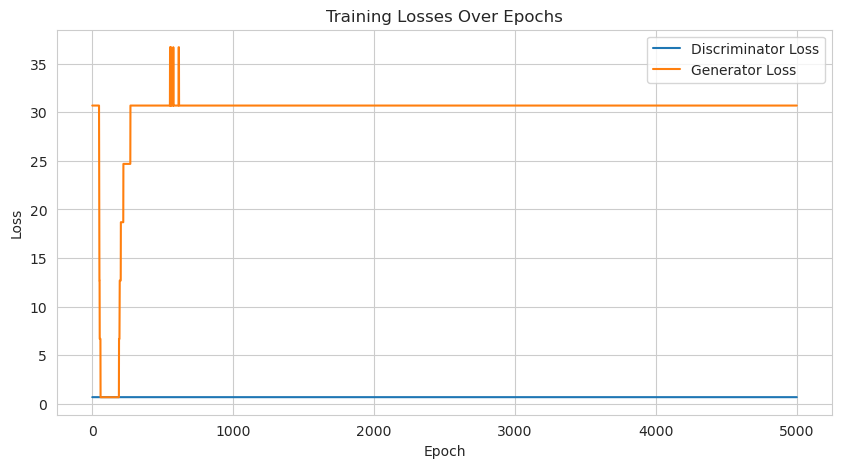

In [192]:
import matplotlib.pyplot as plt

# Assuming `losses` is a list of dictionaries containing 'epoch', 'D Loss', and 'G Loss'
# Extracting the data
epochs_ls = [i for i in range(1, epochs + 1)]  # Integer epochs
d_losses = [loss['D Loss'] for loss in losses]  # Assuming this contains total D loss
g_losses = [loss['G Loss'] for loss in losses]  # Assuming this contains G loss
print(np.mean(d_losses))
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs_ls, d_losses, label='Discriminator Loss')
plt.plot(epochs_ls, g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.savefig('Training_Losses_Over_EpochsCGAN.pdf')
plt.show()


In [193]:
def generate_samples(generator, sample_count, noise_dim, conditions):
    batch_size = len(reshaped_data)  # You can adjust this batch size based on memory constraints
    all_samples = []
    conditions = torch.tensor(conditions, dtype=torch.float).to(device)

    # Calculate number of full batches
    num_full_batches = sample_count // batch_size

    for i in range(num_full_batches):
        # Generate noise for the batch
        noise = generate_noise(batch_size, noise_dim).to(device)
        # Select conditions for the current batch
        batch_conditions = conditions[i * batch_size:(i + 1) * batch_size]
        
        # Generate fake data with conditions
        samples = generator(noise, batch_conditions)
        all_samples.append(samples)
        

    # Handle the remainder if sample_count isn't a perfect multiple of batch_size
    remainder = sample_count % batch_size
    if remainder > 0:
        noise = generate_noise(remainder, noise_dim).to(device)
        batch_conditions = conditions[-remainder:]  # Get the last 'remainder' elements
        samples = generator(noise, batch_conditions)
        all_samples.append(samples)

    # Concatenate all samples into a single array
    return torch.cat(all_samples, dim=0)


# Assuming your generator and noise_dim are defined
noise_dim = 100  # This should match the dimension used during training
sample_count = 30
conditions = reshaped_data[:, :, -2:]  # Extract the last two features across all samples
generated_samples = generate_samples(generator, sample_count, noise_dim, conditions)

In [194]:

generated_samples_second = generate_samples(generator, sample_count, noise_dim, conditions)
generated_samples_third = generate_samples(generator, sample_count, noise_dim, conditions)
generated_samples_forth = generate_samples(generator, sample_count, noise_dim, conditions)


In [195]:
# Concatenate the generated samples
concatenated_tensor = torch.cat((generated_samples, generated_samples_second, generated_samples_third, generated_samples_forth), dim=0)
# Convert to NumPy array (if you need to save it as a .npy file)
concatenated_array = concatenated_tensor.detach().cpu().numpy()
# Save to file
np.save("CGANsyntheticData_100Sample.npy", concatenated_array)
concatenated_array.shape


(120, 5, 27)

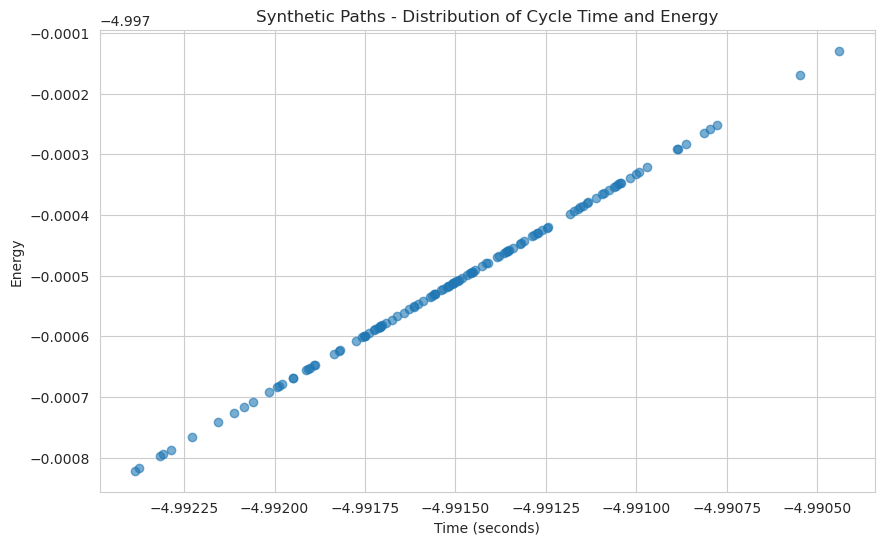

In [196]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(10, 6))
# Selecting the last column from each series
energy_col = concatenated_array[:, :, -1]
energy_sums = np.sum(energy_col, axis=1)
time_col = concatenated_array[:, :, -2]

# Summing across the rows (time steps)
time_sums = np.sum(time_col, axis=1)

plt.scatter(time_sums, energy_sums, alpha=0.6)
plt.title('Synthetic Paths - Distribution of Cycle Time and Energy')
plt.xlabel('Time (seconds)')
plt.ylabel('Energy')
plt.savefig('CGANSynthetic Data - Distribution of Cycle Time and Energy.pdf')
plt.show()


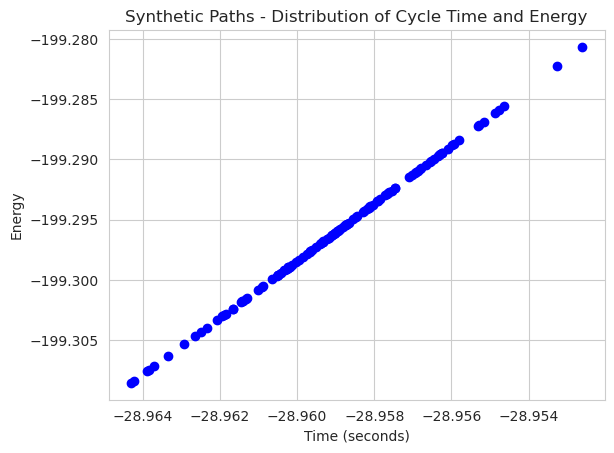

In [197]:

# Extract normalized time and energy into separate variables
denormalize_generated_data = denormalize_data(concatenated_array, scaler, features)
denormalize_generated_data.to_csv("denormalized_sythData_phase1_waed_wgan.csv")

time_denorm = denormalize_generated_data['Time']  # Assuming time is the second last column
energy_denorm = denormalize_generated_data['Energy_Consumped']  # Assuming energy is the last column

# Ensure the series length is a multiple of 5
n = 5
length = len(time_denorm)
trimmed_length = length - (length % n)
# Trim the series if necessary
trimmed_series = time_denorm[:trimmed_length]
# Reshape to groups of 5
reshaped_array = trimmed_series.to_numpy().reshape(-1, n)
# Sum each group of 5
time_denorm_sums = reshaped_array.sum(axis=1)
trimmed_series = energy_denorm[:trimmed_length]
# Reshape to groups of 5
reshaped_array = energy_denorm.to_numpy().reshape(-1, n)
# Sum each group of 5
energy_denorm_sums = reshaped_array.sum(axis=1)

# Plotting
plt.scatter(time_denorm_sums, energy_denorm_sums, color='blue')

# Set title and labels
plt.title('Synthetic Paths - Distribution of Cycle Time and Energy')
plt.xlabel('Time (seconds)')
plt.ylabel('Energy')

# Save and show the plot
plt.savefig('CGANdenormalize-Synthetic Data.pdf')
plt.show()



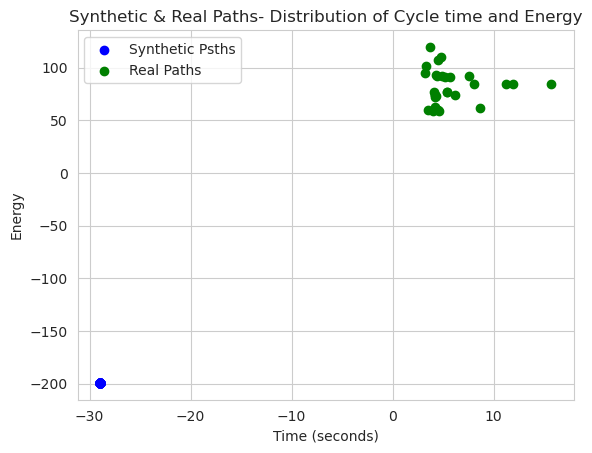

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.set_style('whitegrid')

last_col = real_data.iloc[:, 17]
# Group by each set of five rows and sum
# np.arange(len(last_col)) // 5 creates an integer index for each group of five
energy_real = last_col.groupby(np.arange(len(last_col)) // 5).sum()
last_col = real_data.iloc[:, 16]
time_real = last_col.groupby(np.arange(len(last_col)) // 5).sum()

plt.scatter(time_denorm_sums, energy_denorm_sums, color='blue',label='Synthetic Psths')
plt.scatter(time_real, energy_real, color='green',label='Real Paths')

plt.title('Synthetic & Real Paths- Distribution of Cycle time and Energy')
plt.xlabel('Time (seconds)')
plt.ylabel('Energy')
plt.legend()
plt.savefig('CGANSynthetic & Real Paths- Distribution of Cycle time and Energy.pdf')

plt.show()

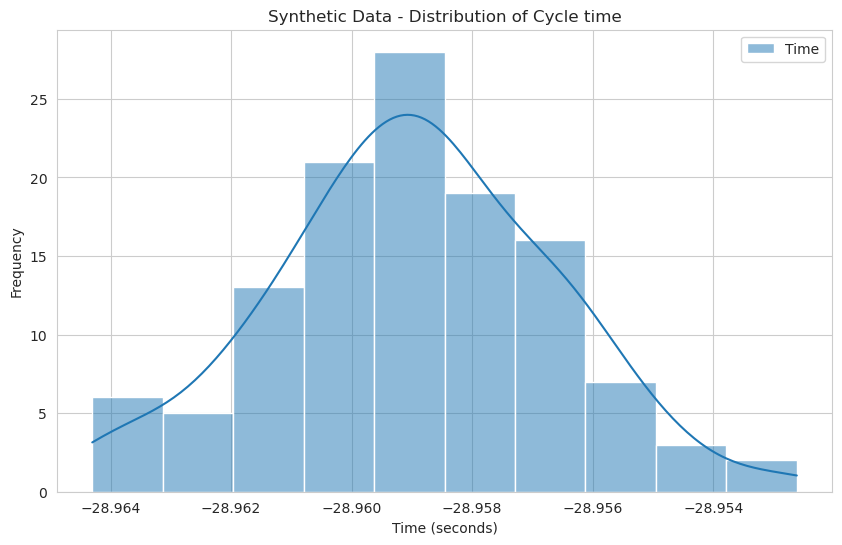

In [199]:
col_16 = time_denorm_sums.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(col_16, kde=True, bins=10 , label = "Time")
plt.title('Synthetic Data - Distribution of Cycle time')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.savefig("CGANdenormalized_data- Sythetic Data - Distribution of Cycle time.pdf")
plt.show()

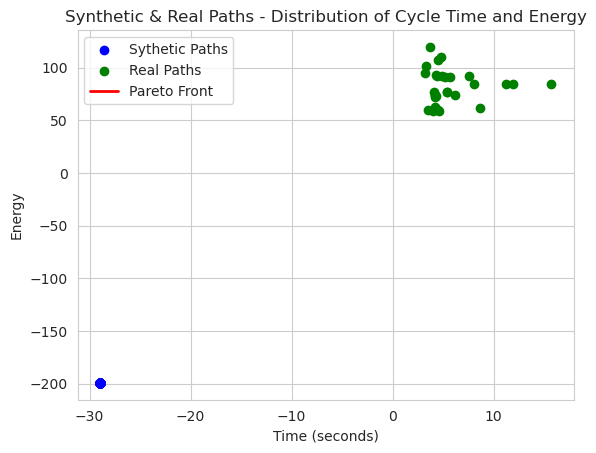

Optimal Points (Min Energy and then Min Time): [(-28.964304, -199.30855)]
[-28.964304] [-199.30855]


In [200]:


# Function to determine the Pareto front for minimizing both dimensions
def pareto_frontier_minimize_both(Xs, Ys):
    sorted_points = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], key=lambda point: (point[0], point[1]))
    pareto_front = [sorted_points[0]]
    for current in sorted_points[1:]:
        if current[1] < pareto_front[-1][1]:
            pareto_front.append(current)
    return [pair[0] for pair in pareto_front], [pair[1] for pair in pareto_front]

# Compute Pareto front
pareto_X, pareto_Y = pareto_frontier_minimize_both(time_denorm_sums, energy_denorm_sums)

# Plotting the points and Pareto front
plt.scatter(time_denorm_sums,energy_denorm_sums, color='blue', label='Sythetic Paths')  # Your original data points
plt.scatter(time_real, energy_real, color='green', label='Real Paths')
plt.plot(pareto_X, pareto_Y, color='red', linewidth=2.0, label='Pareto Front')  # Pareto front

plt.title('Synthetic & Real Paths - Distribution of Cycle Time and Energy')
plt.xlabel('Time (seconds)')
plt.ylabel('Energy')
plt.legend()
plt.savefig('CGANSynthetic & Real Paths- Pareto Visulization.pdf')
plt.show()

# Identifying the absolute optimal point (minimum energy and time)
min_energy = min(pareto_Y)
optimal_points = [(x, y) for x, y in zip(pareto_X, pareto_Y) if y == min_energy]
print("Optimal Points (Min Energy and then Min Time):", optimal_points)
print(pareto_X, pareto_Y)

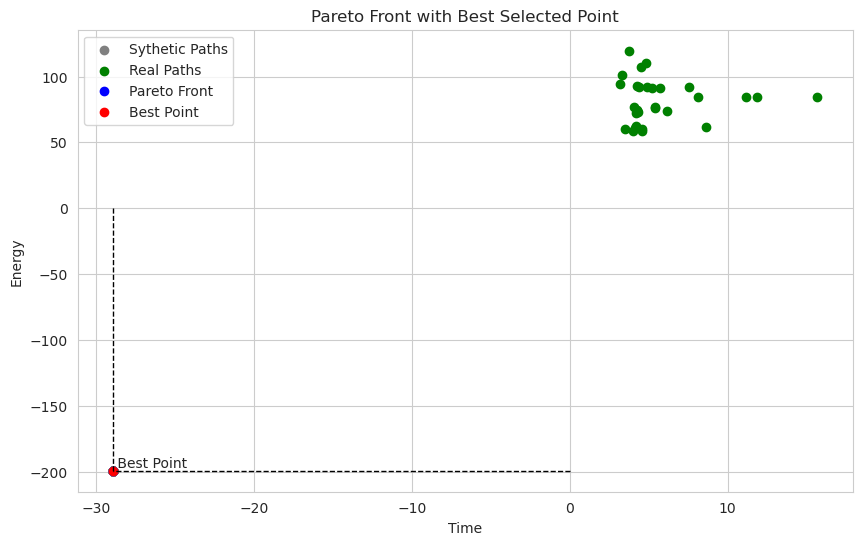

In [201]:

import numpy as np
import matplotlib.pyplot as plt

# Generate random data points for Time and Energy
np.random.seed(0)  # For reproducibility
time = time_denorm_sums
energy = energy_denorm_sums

# Function to identify Pareto optimal points
def identify_pareto(scores):
    # Initialize a boolean array to identify Pareto points
    is_pareto = np.ones(scores.shape[0], dtype=bool)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[0]):
            if all(scores[j] <= scores[i]) and any(scores[j] < scores[i]):
                is_pareto[i] = False
                break
    return is_pareto

# Identify Pareto front
pareto_points = identify_pareto(np.c_[time, energy])
pareto_time = time[pareto_points]
pareto_energy = energy[pareto_points]

# Ensure there are Pareto points before proceeding

if pareto_time.size > 0 and pareto_energy.size > 0:
    # Select the best point based on the shortest Euclidean distance from the origin
    distances = np.sqrt(pareto_time**2 + pareto_energy**2)
    best_index = np.argmin(distances)
    best_time = pareto_time[best_index]
    best_energy = pareto_energy[best_index]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(time, energy, color='gray', label='Sythetic Paths')
    plt.scatter(time_real, energy_real, color='green', label='Real Paths')

    plt.scatter(pareto_time, pareto_energy, color='blue', label='Pareto Front')
    plt.scatter(best_time, best_energy, color='red', label='Best Point')
    plt.plot([0, best_time], [best_energy, best_energy], 'k--', lw=1)  # Horizontal line to Best Point
    plt.plot([best_time, best_time], [0, best_energy], 'k--', lw=1)  # Vertical line to Best Point
    plt.text(best_time, best_energy, ' Best Point', verticalalignment='bottom')
    plt.xlabel('Time')
    plt.ylabel('Energy')
    plt.title('Pareto Front with Best Selected Point')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No Pareto optimal points were identified.")


In [202]:
import math


# Improvement calculation
def improvement_ratio(real, generated):
    time_improvement = (real[0] - generated[0]) / real[0] if real[0] != 0 else 0
    energy_improvement = (real[1] - generated[1]) / real[1] if real[1] != 0 else 0
    return time_improvement, energy_improvement

# Example usage:
real_point = (3.18, 58.5091)
generated_point = (best_time, best_energy)


# Get improvements
time_improvement, energy_improvement = improvement_ratio(real_point, generated_point)



print(f"Time Improvement Ratio: {time_improvement:.2%}")
print(f"Energy Improvement Ratio: {energy_improvement:.2%}")
generated_point

Time Improvement Ratio: 1010.83%
Energy Improvement Ratio: 440.65%


(-28.964304, -199.30855)

In [203]:
indexes_phase1=[]
data = {
    'Time': denormalize_generated_data['Time'],   # Replace 50 with the actual size
    'Energy_Consumped': denormalize_generated_data['Energy_Consumped']
}
df_indexes = pd.DataFrame(data)

# Group by every five rows and sum
grouping_key = np.floor(np.arange(len(df_indexes)) / 5)

grouped = df_indexes.groupby(grouping_key).sum()
grouped['Index'] = grouped.index.astype(int) * 5  

for t, e in zip(pareto_time, pareto_energy):
    print(t,e)
    try:
        index = int(grouped[grouped['Time'] == t].index[0])
        index_2 = int(grouped[grouped['Energy_Consumped'] == e].index[0])
    except IndexError:
        index = None
        index_2 = None
    if (index ==index_2):
        indexes_phase1.append(index)

# Convert to a DataFrame
df_indexes = pd.DataFrame(indexes_phase1, columns=['path_index'])
df_indexes.drop_duplicates(inplace=True)
# Save to a CSV file
df_indexes.to_csv('pathes_index_phase1.csv', index=False)
denormalize_generated_data

-28.964304 -199.30855


,point_type,Tool_x,Tool_y,Tool_z,Speed,Acceleration,Movement Type,Time,Energy_Consumped,Tool_rx,Tool_ry,Tool_rz,Joint_base,Joint_Shoulder,Joint_Elbow,Joint_W1,Joint_W2,Joint_W3
0,0.998571,-0.997045,-0.118512,0.999315,898.557434,1831.346558,0.998995,-5.753919,-39.783550,-0.786451,0.788184,-2.356944,-2.355024,0.789912,0.787163,0.785105,-2.356341,-0.784692
1,0.999988,-0.999973,-0.792291,0.999997,899.987915,1839.776001,0.999995,-5.801072,-39.878300,-0.785414,0.785460,-2.356208,-2.356177,0.785493,0.785477,0.785395,-2.356196,-0.785389
2,0.999997,-0.999993,-0.902179,0.999999,899.996399,1839.905884,0.999999,-5.801690,-39.878983,-0.785403,0.785420,-2.356199,-2.356189,0.785431,0.785434,0.785397,-2.356195,-0.785395
3,0.999998,-0.999995,-0.918561,1.000000,899.997314,1839.924438,0.999999,-5.801764,-39.879059,-0.785402,0.785415,-2.356198,-2.356190,0.785423,0.785428,0.785397,-2.356195,-0.785396
4,0.999998,-0.999995,-0.922340,1.000000,899.997620,1839.929443,0.999999,-5.801782,-39.879078,-0.785402,0.785413,-2.356198,-2.356191,0.785421,0.785426,0.785398,-2.356195,-0.785396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.998523,-0.996954,-0.115458,0.999290,898.508179,1831.112061,0.998958,-5.752628,-39.780464,-0.786481,0.788255,-2.356963,-2.354991,0.790025,0.787201,0.785096,-2.356346,-0.784672
596,0.999988,-0.999973,-0.791036,0.999997,899.987671,1839.773804,0.999995,-5.801061,-39.878288,-0.785414,0.785461,-2.356208,-2.356177,0.785495,0.785478,0.785395,-2.356196,-0.785389
597,0.999997,-0.999993,-0.902014,0.999999,899.996399,1839.905762,0.999999,-5.801689,-39.878983,-0.785403,0.785419,-2.356199,-2.356189,0.785431,0.785434,0.785397,-2.356195,-0.785395
598,0.999998,-0.999995,-0.918521,1.000000,899.997314,1839.924438,0.999999,-5.801763,-39.879059,-0.785402,0.785415,-2.356198,-2.356190,0.785423,0.785428,0.785397,-2.356195,-0.785396


# Phase 2  , Take the fav/accurate points from the engineer then re-fine-tune the generator 

In [204]:
# Load the trained model weights
generator.load_state_dict(torch.load('generator_model_phase1.pth'))
discriminator.load_state_dict(torch.load('discriminator_model_phase1.pth'))

optimizer_g, optimizer_d, device = setup_gan(generator, discriminator, lr=0.0001)

discriminator
Discriminator(
  (lstm1): LSTM(29, 1024, batch_first=True)
  (lstm2): LSTM(1024, 256, batch_first=True)
  (lstm3): LSTM(256, 128, batch_first=True)
  (lstm4): LSTM(128, 32, batch_first=True)
  (lstm5): LSTM(32, 32, batch_first=True)
  (lstm6): LSTM(32, 32, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): LeakyReLU(negative_slope=0.2)
)


In [205]:
!pip install onnx-tf


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


### Value Network:


The value network estimates the expected reward for a given state. In our context, it helps evaluate how good the generated samples are, based on the human feedback.
The value network is a separate neural network that takes the same input as the generator and outputs a single value representing the expected reward.

In [206]:
def collect_human_feedback(samples):
    # Ensure samples are on GPU
    samples = samples.to(device)
    alpha = 0.5
    feedback =[]
    for sample in samples:
        #lower values are better
        rating = (sample[:,-2].sum() * alpha + sample[:,-1].sum() *(1-alpha))
        feedback.append(float(rating))
    
    return torch.tensor(feedback, dtype=torch.float).to(device)

### 3. Define RL Components

In [207]:
import torch
import torch.nn as nn
import torch.optim as optim

# Assuming `generator_ph1` is your policy network and already defined
policy_network = generator

# Define the value network in PyTorch
class ValueNetwork(nn.Module):
    def __init__(self, input_features):
        super(ValueNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(input_features, 128)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        return x

# Assume 'features' is defined elsewhere and provides the number of input features
input_dim = 5 * len(features)  # Update with the actual size of 'features'
value_network = ValueNetwork(input_dim).to(device)

optimizer_value = optim.Adam(value_network.parameters(), lr=0.0001)


### 4. Modify GAN Training Loop

In [208]:
# Define the loss function
criterion = nn.BCELoss()

def train_ph2(generator, discriminator, optimizer_g, optimizer_d, device, epochs, noise_dim,  hfrl_paths_normalized_3d, value_network, optimizer_value, conditions, phy_factor_param):
    losses_ph2 = []
    # Convert reshaped_data and conditions to PyTorch tensors and move to device
    reshaped_data_tensor = torch.tensor(hfrl_paths_normalized_3d, dtype=torch.float32).to(device)
    conditions = torch.tensor(conditions, dtype=torch.float32).to(device)

    losses = []

    for epoch in range(epochs):
        # Generate real data samples
        real_data_batch = reshaped_data_tensor
        gen_conditions = conditions

        # Generate synthetic data samples
        
        noise = generate_noise(len(real_data_batch), noise_dim).to(device)
     
        fake_data = generator(noise, gen_conditions)
        # === Train Discriminator ===
        optimizer_d.zero_grad()
        real_validity = discriminator(real_data_batch, gen_conditions)
        fake_validity = discriminator(fake_data.detach(), gen_conditions)

        # Real data loss
        real_loss = criterion(real_validity, torch.ones_like(real_validity)) 
        # Fake data loss
        fake_loss = criterion(fake_validity, torch.zeros_like(fake_validity))
        
        d_loss = (real_loss + fake_loss) / 2 
        d_loss.backward()
        optimizer_d.step()
        ########################################
        # Update Value Network
        feedback = collect_human_feedback(fake_data)
        optimizer_value.zero_grad()
        mse_loss = nn.MSELoss()
        if isinstance(fake_data, list):
            fake_data = torch.tensor(fake_data, dtype=torch.float).to(device)  # Convert list to tensor
        predicted_feedback = value_network(fake_data)
        
        #feedback = feedback.view(1, 1)
        feedback = feedback.view(predicted_feedback.shape)

        value_loss = mse_loss(feedback, predicted_feedback)
        value_loss.backward(retain_graph=True)
        optimizer_value.step()
        ########################################
        # === Train Generator ===
        optimizer_g.zero_grad()
        # Generate fake data again for generator update
        fake_data = generator(noise, gen_conditions)
        fake_validity = discriminator(fake_data, gen_conditions)

        g_loss = criterion(fake_validity, torch.ones_like(fake_validity)) 
        #lower values are better
        #modify the generator's loss to include this feedback negatively (since you typically minimize loss)
        val_factor = 1
        phy_loss = physics_loss(fake_data)
        total_g_loss = g_loss +val_factor * value_loss.detach() + phy_factor_param * phy_loss  # where lambda is a weighting factor
        total_g_loss.backward()
        optimizer_g.step()
         
        losses_ph2.append({"epoch": epoch, "D Loss": d_loss.item(), "G Loss": total_g_loss.item(), "Value Loss": value_loss.item()})
        print(f"Epoch {epoch+1}/{epochs}, D Loss: {d_loss.item()}, G Loss: {total_g_loss.item()}, Value Loss: {value_loss.item()}")

    return losses_ph2

In [209]:
#hfrl_paths = pd.read_csv("waeeeed paths after engineer review it.csv")
hfrl_paths = pd.read_csv("phase RLHF dataset/least_energy_time_paths.csv")


#############

# Fix a typo in the 'point_type' column
real_data['point_type'] = hfrl_paths['point_type'].replace('approuch', 'approach')

# Map 'point_type' and 'Movement Type' to numeric values
points = {'pick': 1, 'approach': 2, 'start_point': 3, 'box1': 4, 'way_point': 5}
movement_types = {'MoveL': 1, 'MoveJ': 2, 'Movel': 1, 'Movej': 2}
hfrl_paths['point_type'] = hfrl_paths['point_type'].map(points)
hfrl_paths['Movement Type'] = hfrl_paths['Movement Type'].map(movement_types)

# Drop columns 'id' and 'row_index'
hfrl_paths.drop(['id'], axis=1, inplace=True)

#############
hfrl_paths_normalized, scaler_ph2 = normalizaData(hfrl_paths)
#exclude the  Joint_W3 and keep sin , cos
hfrl_paths_normalized= hfrl_paths_normalized[features]
num_paths = len(hfrl_paths) // 5
batch_size = num_paths #all data 

path_id = np.repeat(np.arange(num_paths), 5)
hfrl_paths_normalized['path_id'] = path_id
grouped = hfrl_paths_normalized.groupby('path_id').apply(lambda x: x.values[:, :-1].reshape(1, 5,features_num))
hfrl_paths_normalized.drop(['path_id'], axis=1, inplace=True)


# Concatenate the groups back into a single numpy array
hfrl_paths_normalized_3d = np.concatenate(grouped.values, axis=0)

optimizer_g, optimizer_d, device = setup_gan(generator, discriminator, lr=0.0001)
conditions = hfrl_paths_normalized_3d[:, :, -2:]  
losses_ph2 =  train_ph2(generator, discriminator, optimizer_g, optimizer_d, device, epochs, noise_dim, hfrl_paths_normalized_3d, value_network, optimizer_value, conditions, best_params["phy_factor_param"])


/tmp/ipykernel_158/81852580.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hfrl_paths_normalized['path_id'] = path_id
/tmp/ipykernel_158/81852580.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = hfrl_paths_normalized.groupby('path_id').apply(lambda x: x.values[:, :-1].reshape(1, 5,features_num))
/tmp/ipykernel_158/81852580.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats i

discriminator
Discriminator(
  (lstm1): LSTM(29, 1024, batch_first=True)
  (lstm2): LSTM(1024, 256, batch_first=True)
  (lstm3): LSTM(256, 128, batch_first=True)
  (lstm4): LSTM(128, 32, batch_first=True)
  (lstm5): LSTM(32, 32, batch_first=True)
  (lstm6): LSTM(32, 32, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): LeakyReLU(negative_slope=0.2)
)
Epoch 1/5000, D Loss: 0.7117397785186768, G Loss: 8.172043800354004, Value Loss: 7.192718982696533
Epoch 2/5000, D Loss: 0.7157567143440247, G Loss: 8.166170120239258, Value Loss: 7.170365333557129
Epoch 3/5000, D Loss: 0.7040472626686096, G Loss: 8.232763290405273, Value Loss: 7.218695640563965
Epoch 4/5000, D Loss: 0.6906698942184448, G Loss: 8.115251541137695, Value Loss: 7.106918811798096
Epoch 5/5000, D Loss: 0.7067888379096985, G Loss: 8.044373512268066, Value Loss: 7.098870277404785
Epoch 6/5000, D Loss: 0.6791938543319702, G Loss: 

KeyboardInterrupt: 

In [ ]:
# Extracting the data

#Epoch: 41, Batch: 34, D Loss: 0.7058187127113342, G Loss: 0.6761125326156616, Value Loss: 9.605087280273438

epochs_ls = [loss['epoch'] for loss in losses_ph2]
d_losses = [loss['D Loss'] for loss in losses_ph2]
g_losses = [loss['G Loss'] for loss in losses_ph2]
value_losses =  [loss['Value Loss'] for loss in losses_ph2]
d_losses_real = []
d_losses_fake = []
print(np.mean(d_losses),"d_losses")
print(np.mean(g_losses),"g_losses")
print(np.mean(value_losses),"value_losses")



# Plotting
plt.figure(figsize=(10, 5))
#d_loss_real
plt.plot(epochs_ls, d_losses, label='Discriminator Loss')

plt.plot(epochs_ls, g_losses, label='Generator Loss')
plt.plot(epochs_ls, value_losses, label='Reward Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()
plt.savefig('CGANTraining Losses Over Epochs 100ep.pdf')
plt.show()

In [ ]:
# Generate samples
noise_dim = 100  # This should match the dimension used during training
sample_count = 1
generated_samples = generate_samples(generator, sample_count, noise_dim, conditions)
generated_samples_second = generate_samples(generator, sample_count, noise_dim, conditions)
generated_samples_third = generate_samples(generator, sample_count, noise_dim, conditions)
generated_samples_forth = generate_samples(generator, sample_count, noise_dim, conditions)

print(generated_samples.shape)
    
samples_syth =  torch.cat((generated_samples, generated_samples_second, generated_samples_third, generated_samples_forth), dim=0)


# Convert to NumPy array (if you need to save it as a .npy file)
samples_syth = samples_syth.detach().cpu().numpy()

In [ ]:
# Generate samples
noise_dim = 100  # This should match the dimension used during training
sample_count = 1000

# Generate samples using a for loop
samples_syth = []
for i in range(sample_count):
    sample = generate_samples(generator, 1 , noise_dim, conditions)
    samples_syth.append(sample)
    
samples_syth = torch.cat(samples_syth, dim=0).to('cpu').detach().numpy()

samples_syth.shape

### Denormalize Dataset

In [ ]:
samples_syth_ph2 = denormalize_data(samples_syth, scaler_ph2, features)
samples_syth_ph2.head(2)

In [ ]:

# Extract normalized time and energy into separate variables
denormalize_generated_data = samples_syth_ph2

time_denorm = samples_syth_ph2['Time']  # Assuming time is the second last column
energy_denorm = samples_syth_ph2['Energy_Consumped']  # Assuming energy is the last column

# Ensure the series length is a multiple of 5
n = 5
length = len(time_denorm)
trimmed_length = length - (length % n)
# Trim the series if necessary
trimmed_series = time_denorm[:trimmed_length]
# Reshape to groups of 5
reshaped_array = trimmed_series.to_numpy().reshape(-1, n)
# Sum each group of 5
time_denorm_sums = reshaped_array.sum(axis=1)
trimmed_series = energy_denorm[:trimmed_length]
# Reshape to groups of 5
reshaped_array = energy_denorm.to_numpy().reshape(-1, n)
# Sum each group of 5
energy_denorm_sums = reshaped_array.sum(axis=1)

# Plotting
plt.scatter(time_denorm_sums, energy_denorm_sums, color='blue')

# Set title and labels
plt.title('Synthetic Paths - Distribution of Cycle Time and Energy')
plt.xlabel('Time (seconds)')
plt.ylabel('Energy')

# Save and show the plot
plt.savefig(',CGANdenormalize-Synthetic Data.pdf')
plt.show()

In [ ]:
time = time_denorm_sums
energy =energy_denorm_sums

# Function to identify Pareto optimal points
def identify_pareto(scores):
    # Initialize a boolean array to identify Pareto points
    is_pareto = np.ones(scores.shape[0], dtype=bool)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[0]):
            if all(scores[j] <= scores[i]) and any(scores[j] < scores[i]):
                is_pareto[i] = False
                break
    return is_pareto

# Identify Pareto front
pareto_points = identify_pareto(np.c_[time, energy])
pareto_time = time[pareto_points]
pareto_energy = energy[pareto_points]

# Ensure there are Pareto points before proceeding

if pareto_time.size > 0 and pareto_energy.size > 0:
    # Select the best point based on the shortest Euclidean distance from the origin
    distances = np.sqrt(pareto_time**2 + pareto_energy**2)
    best_index = np.argmin(distances)
    best_time = pareto_time[best_index]
    best_energy = pareto_energy[best_index]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(time, energy, color='gray', label='Sythetic Paths')
    plt.scatter(time_real, energy_real, color='green', label='Real Paths')

    plt.scatter(pareto_time, pareto_energy, color='blue', label='Pareto Front')
    plt.scatter(best_time, best_energy, color='red', label='Best Point')
    plt.plot([0, best_time], [best_energy, best_energy], 'k--', lw=1)  # Horizontal line to Best Point
    plt.plot([best_time, best_time], [0, best_energy], 'k--', lw=1)  # Vertical line to Best Point
    plt.text(best_time, best_energy, ' Best Point', verticalalignment='bottom')
    plt.xlabel('Time')
    plt.ylabel('Energy')
    plt.title('Pareto Front with Best Selected Point')
    plt.legend()
    plt.grid(True)
    plt.savefig('paretofront best selected cgan ph2.pdf')
    #plt.show()
else:
    print("No Pareto optimal points were identified.")
print(best_time,best_energy)

In [ ]:
import math


# Improvement calculation
def improvement_ratio(real, generated):
    time_improvement = (real[0] - generated[0]) / real[0] if real[0] != 0 else 0
    energy_improvement = (real[1] - generated[1]) / real[1] if real[1] != 0 else 0
    return time_improvement, energy_improvement

# Example usage:
real_point = (3.18, 58.5091)
generated_point = (best_time, best_energy)


# Get improvements
time_improvement, energy_improvement = improvement_ratio(real_point, generated_point)



print(f"Time Improvement Ratio: {time_improvement:.2%}")
print(f"Energy Improvement Ratio: {energy_improvement:.2%}")

In [ ]:
import torch
import torch.nn as nn
from torchviz import make_dot

# Define your model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

model = SimpleModel()
x = torch.randn(1, 10)
y = model(x)

# Visualize the model
dot = make_dot(y, params=dict(model.named_parameters()))
dot.format = 'png'
dot.render('model_architecture')
